<a href="https://colab.research.google.com/github/ForThisPlayer10/neural/blob/main/imdb-sentiment_analysis_keras/sample_imdb_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

In [1]:
! wget https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/a1_IMDB_Dataset.csv
! wget https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/a2_IMDb_Unseen_Reviews.csv
! wget https://media.githubusercontent.com/media/rohanrao619/Twitter_Sentiment_Analysis/master/glove.6B.100d.txt

--2024-07-24 18:28:34--  https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/a1_IMDB_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66212309 (63M) [text/plain]
Saving to: ‘a1_IMDB_Dataset.csv’

a1_IMDB_Dataset.csv 100%[===================>]  63.14M  95.0MB/s    in 0.7s    

2024-07-24 18:28:35 (95.0 MB/s) - ‘a1_IMDB_Dataset.csv’ saved [66212309/66212309]

--2024-07-24 18:28:36--  https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/a2_IMDb_Unseen_Reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:44

In [2]:
%pip install tensorflow keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 738.3 kB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

## Loading dataset

In [4]:
movie_reviews = pd.read_csv('./a1_IMDB_Dataset.csv')

In [5]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Checking if null values exist
movie_reviews.isnull().values.any()

False

## Data Preprocessing

In [7]:
movie_reviews['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text)

import nltk
nltk.download('stopwords')

def preprocess_text(text):
  sentence = text.lower()
  # Remove html tags
  sentence = remove_tags(sentence)
  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
  # Remove multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
  # Remove Stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sentence = pattern.sub('', sentence)
  return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [10]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

## Preparing embedding layer

In [12]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [13]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92362

In [14]:
# Padding all reviews to 100 length
maxlen = 100

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

In [16]:
from numpy import asarray, zeros

embeddings_dict = dict()
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dim = asarray(records[1:], dtype="float32")
  embeddings_dict[word] = vector_dim

glove_file.close()

In [17]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(92362, 100)

## Model Training

### Artificial Neural Network

In [18]:
ann_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)


ann_model.add(embedding_layer)
ann_model.add(Flatten())
ann_model.add(Dense(1, activation='sigmoid'))

In [19]:
ann_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9236200   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9246201 (35.27 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9236200 (35.23 MB)
_________________________________________________________________


In [20]:
ann_model_history = ann_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 5s 17ms/step - loss: 0.5629 - acc: 0.7127 - val_loss: 0.5133 - val_acc: 0.7546
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4485 - acc: 0.7980 - val_loss: 0.5034 - val_acc: 0.7606
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4120 - acc: 0.8173 - val_loss: 0.5136 - val_acc: 0.7564
Epoch 4/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3890 - acc: 0.8295 - val_loss: 0.5256 - val_acc: 0.7563
Epoch 5/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3743 - acc: 0.8370 - val_loss: 0.5441 - val_acc: 0.7527
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3631 - acc: 0.8411 - val_loss: 0.5503 - val_acc: 0.7500


In [21]:
ann_score = ann_model.evaluate(X_test, y_test, verbose=1)

print(f'Test score: {ann_score[0]}\nTest accuracy: {ann_score[1]}')

313/313 [==============================] - 1s 2ms/step - loss: 0.5554 - acc: 0.7536
Test score: 0.5554406046867371
Test accuracy: 0.753600001335144


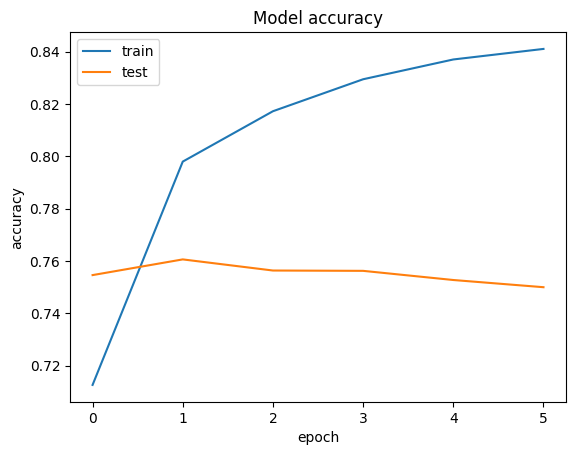

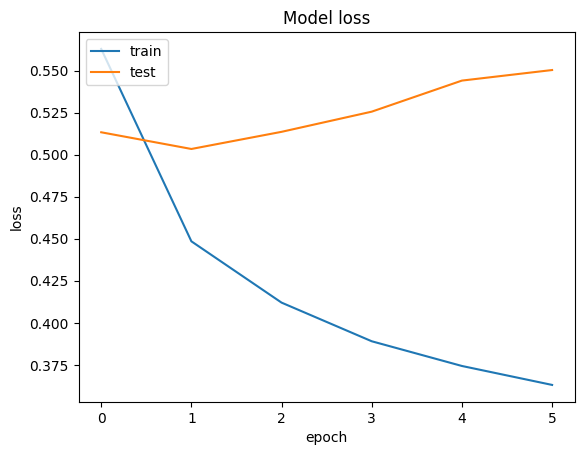

In [22]:
# Charts
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(ann_model_history.history['acc'])
plt.plot(ann_model_history.history['val_acc'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper left")
plt.show()

plt.plot(ann_model_history.history['loss'])
plt.plot(ann_model_history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper left")
plt.show()

### Convolutional Neural Network

In [23]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation="sigmoid"))

In [27]:
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9236200   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9300457 (35.48 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9236200 (35.23 MB)
_________________________________________________________________


In [31]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 27s 107ms/step - loss: 0.1344 - acc: 0.9669 - val_loss: 0.3483 - val_acc: 0.8531
Epoch 2/6
250/250 [==============================] - 30s 120ms/step - loss: 0.1068 - acc: 0.9788 - val_loss: 0.3461 - val_acc: 0.8541
Epoch 3/6
250/250 [==============================] - 26s 106ms/step - loss: 0.0869 - acc: 0.9851 - val_loss: 0.3840 - val_acc: 0.8424
Epoch 4/6
250/250 [==============================] - 30s 122ms/step - loss: 0.0657 - acc: 0.9942 - val_loss: 0.3649 - val_acc: 0.8559
Epoch 5/6
250/250 [==============================] - 30s 120ms/step - loss: 0.0523 - acc: 0.9969 - val_loss: 0.3767 - val_acc: 0.8535
Epoch 6/6
250/250 [==============================] - 26s 106ms/step - loss: 0.0409 - acc: 0.9988 - val_loss: 0.3889 - val_acc: 0.8546


In [32]:
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)

print(f'Test score: {cnn_score[0]}\nTest accuracy: {cnn_score[1]}')

313/313 [==============================] - 6s 18ms/step - loss: 0.3843 - acc: 0.8594
Test score: 0.38433361053466797
Test accuracy: 0.8593999743461609


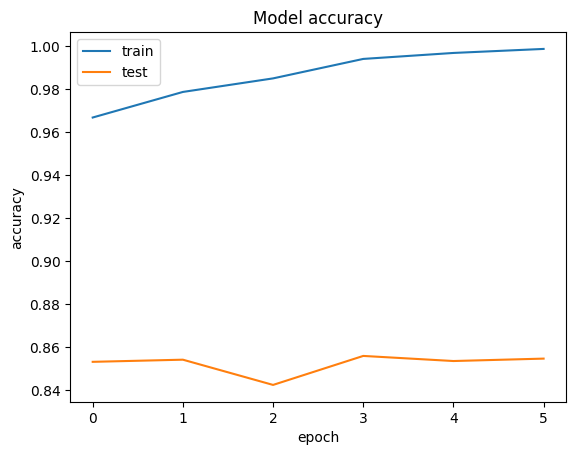

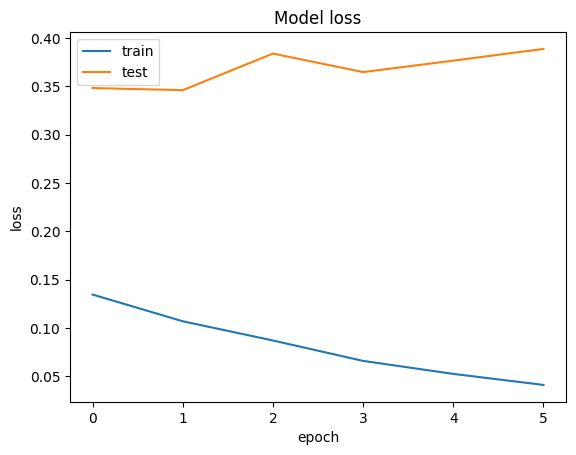

In [33]:
# Charts
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper left")
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper left")
plt.show()

### Recurrent Neural Network

In [35]:
from keras.layers import LSTM

In [37]:
rnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
rnn_model.add(embedding_layer)

rnn_model.add(LSTM(128))
rnn_model.add(Dense(1, activation='sigmoid'))

In [38]:
rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9236200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9353577 (35.68 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9236200 (35.23 MB)
_________________________________________________________________


In [39]:
rnn_model_history = rnn_model.fit(X_train, y_train, verbose=1, epochs=6, batch_size=128, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 120s 457ms/step - loss: 0.5133 - acc: 0.7499 - val_loss: 0.4367 - val_acc: 0.8056
Epoch 2/6
250/250 [==============================] - 107s 429ms/step - loss: 0.4261 - acc: 0.8098 - val_loss: 0.4131 - val_acc: 0.8089
Epoch 3/6
250/250 [==============================] - 133s 531ms/step - loss: 0.3826 - acc: 0.8308 - val_loss: 0.3535 - val_acc: 0.8503
Epoch 4/6
250/250 [==============================] - 104s 414ms/step - loss: 0.3423 - acc: 0.8529 - val_loss: 0.3524 - val_acc: 0.8514
Epoch 5/6
250/250 [==============================] - 104s 414ms/step - loss: 0.3242 - acc: 0.8627 - val_loss: 0.3204 - val_acc: 0.8602
Epoch 6/6
250/250 [==============================] - 104s 415ms/step - loss: 0.3047 - acc: 0.8744 - val_loss: 0.3264 - val_acc: 0.8549


In [40]:
rnn_score = rnn_model.evaluate(X_test, y_test, verbose=1)
print(f'Test score: {rnn_score[0]}\nTest accuracy: {rnn_score[1]}')

313/313 [==============================] - 25s 80ms/step - loss: 0.3197 - acc: 0.8640
Test score: 0.3196612298488617
Test accuracy: 0.8640000224113464


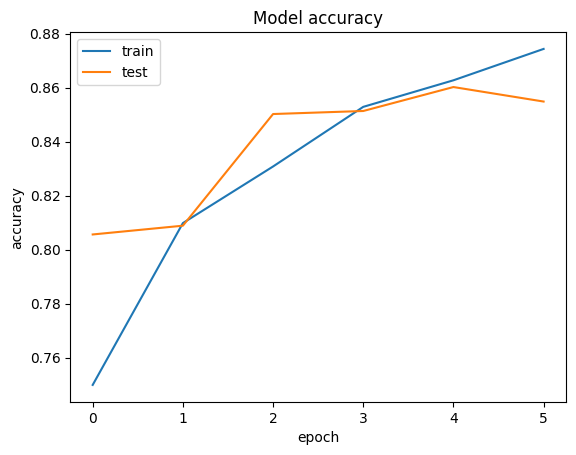

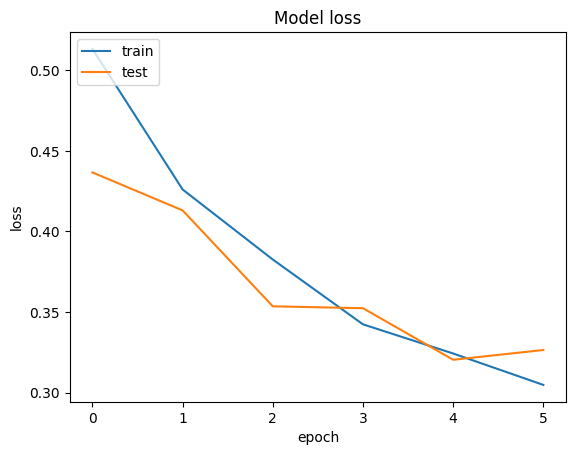

In [41]:
# Charts
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rnn_model_history.history['acc'])
plt.plot(rnn_model_history.history['val_acc'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper left")
plt.show()

plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper left")
plt.show()

In [43]:
rnn_model.save(f'./c_rnn_model_acc{round(rnn_score[1], 3)}.h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predicting new, live data

In [48]:
sample_reviews = pd.read_csv('./a2_IMDb_Unseen_Reviews.csv')
sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [51]:
unseen_reviews = sample_reviews['Review Text']
unseen_processed = []

for line in unseen_reviews:
  unseen_processed.append(preprocess_text(line))

In [52]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [53]:
unseen_predicts = rnn_model.predict(unseen_padded, verbose=1)

1/1 [==============================] - 2s 2s/step


In [57]:
sample_reviews['Model prediction'] = np.round(unseen_predicts*10,2)

df_prediction = pd.DataFrame(sample_reviews['Model prediction'], columns=['Model prediction'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns=['Movie'])
df_review = pd.DataFrame(sample_reviews['Review Text'], columns=['Review Text'])
df_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns=['IMDb Rating'])

dfx = pd.concat([df_movie, df_review, df_rating, df_prediction], axis=1)

dfx.to_csv('./c_unseen_predictions.csv', encoding="UTF-8", sep=',')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Model prediction
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.29
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.91
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,5.53
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.13
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.74
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.37


## Playground

In [71]:
new_review = input('Whats your review?')

Whats your review?It was amazing! I couldn't believe it was so good!


In [72]:
new_review_arr = [preprocess_text(new_review)]
new_review_processed = pad_sequences(word_tokenizer.texts_to_sequences(new_review_arr), padding="post", maxlen=maxlen)
new_review_prediction = rnn_model.predict(new_review_processed)
print(f"Your rating is: {np.round(new_review_prediction*10, 2)}")

1/1 [==============================] - 0s 59ms/step
Your rating is: [[9.69]]
